# Human Protein Atlas Competition!

CS152 Neural Networks, Fall 2018, Harvey Mudd College
Collaborator: Carrie Yang, Ivy Liu, Laurel Newman

Adapted from https://www.kaggle.com/allunia/protein-atlas-exploration-and-baseline

## Project Motivation

Develop a model “capable of classifying mixed patterns of proteins in microscope images” to be “integrated with [The Human Protein Atlas’] smart-microscopy system to identify a protein’s location(s) from a high-throughput image.”


## Our goal

* Predict various protein structures in cellular images
* there are 28 different target proteins
* multiple proteins can be present in one image (multilabel classification)
* 27 different cell types of highly different morphology

## Log of time spent on the project

We worked 6 hours per week for five weeks. Therefore, a total number of 30 hours.

* First week, we decided our project and did some initial search on finding a baseline model that work on our problem. We also met with Prof. Rhodes to discuss our project.

* Second week, we start with some data exploration. However, we encountered a lot of problem when we use Google Compute Engine. 

* Third week, we tried to download data into Google Compute Engine using Google Storage Bucket, and start runnning the baseline model.

* Fourth week, we finally figured out how to use Kaggle Kernel to run the python notebook and got some prelimiary result.

* Fifth week, we did final presetation, and got more training results. 

## Improved model settings


In [1]:
use_dropout=False

## Loading packages and data

The data is “high-throughput images” which is an automated  method whereby researchers process large quantities of samples. Different types of proteins can be stained different colors such that researchers can then visually identify them.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imread

import tensorflow as tf
sns.set()

import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test', 'train', 'train.csv']


In [3]:
train_labels = pd.read_csv("../input/train.csv")
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


How many samples do we have?

In [4]:
train_labels.shape[0]

31072

## Helper code

In [5]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

#adding more columns specifying whether any specific organelle appears
def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

## Which proteins occur most often in images?

In [6]:
for key in label_names.keys():
    train_labels[label_names[key]] = 0

In [7]:
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


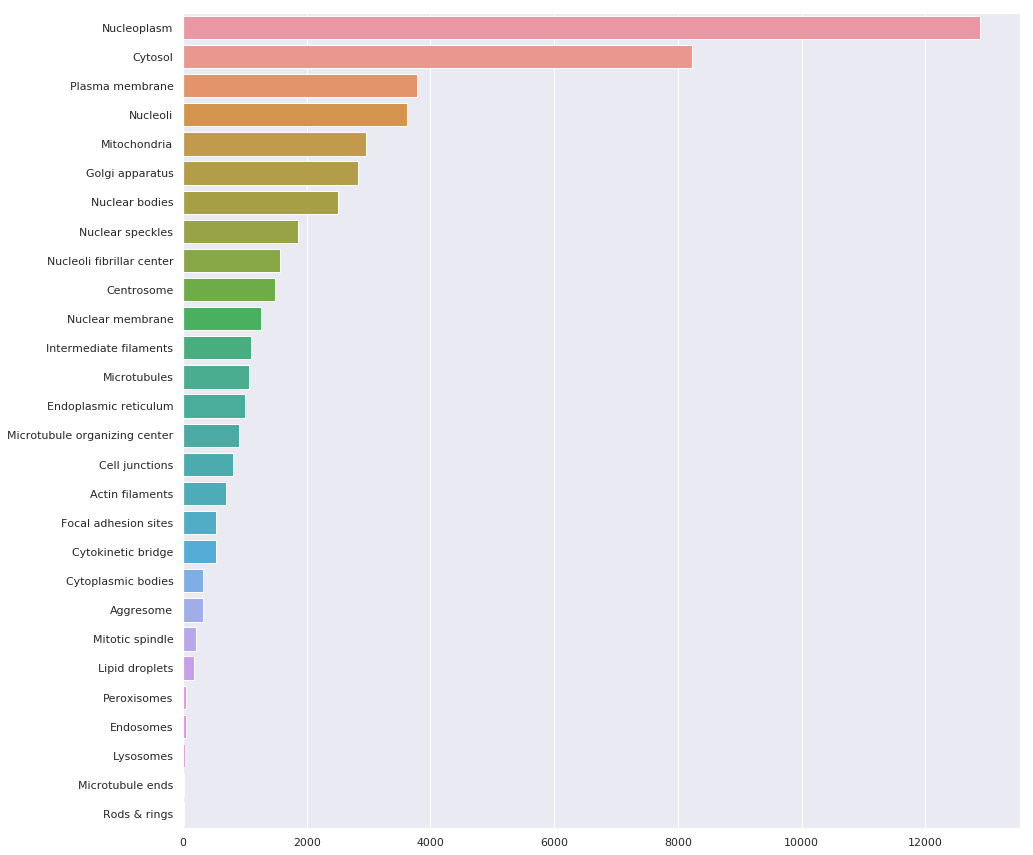

In [8]:
#generates a bar plot for the frequency of targets
target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

### Take-Away

* We can see that most common protein structures belong to coarse grained cellular components like the plasma membrane, the cytosol and the nucleus. 
* In contrast small components like the lipid droplets, peroxisomes, endosomes, lysosomes, microtubule ends, rods and rings are very seldom in our train data. For these classes the prediction will be very difficult as we have only a few examples that may not cover all variabilities and as our model probably will be confused during the learning process by the major classes. Due to this confusion we will make less accurate predictions on the minor classes.
* Consequently accuracy is not the right score here to measure your performance and validation strategy should be very fine. 

## How many targets are most common?

Text(0, 0.5, '% of data')

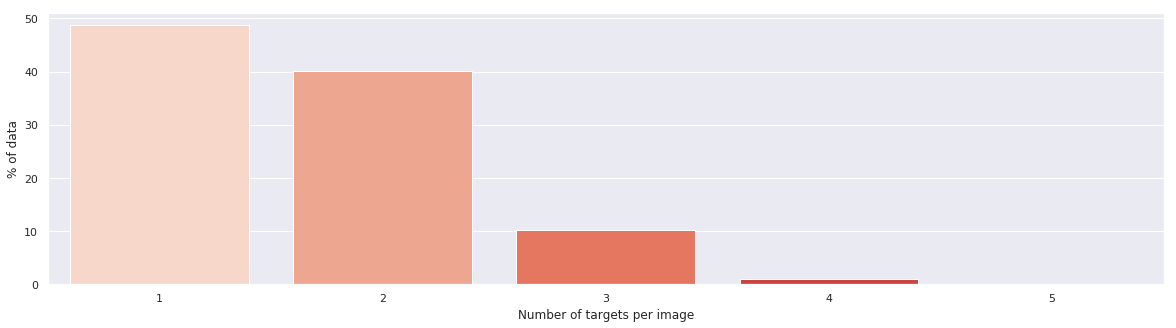

In [9]:
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)
count_perc = np.round(100 * train_labels["number_of_targets"].value_counts() / train_labels.shape[0], 2)
plt.figure(figsize=(20,5))
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette="Reds")
plt.xlabel("Number of targets per image")
plt.ylabel("% of data")

### Take-away

* Most train images only have 1 or two target labels.
* More than 3 targets are very seldom!

## How do the images look like?



### Peek into the directory

Before we start loading images, let's have a look into the train directory to get an impression of what we can find there:

In [10]:
from os import listdir

files = listdir("../input/train")
for n in range(10):
    print(files[n])

a39d2b94-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
5c4afeae-bbab-11e8-b2ba-ac1f6b6435d0_green.png
a480418c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
7e3c58ee-bbad-11e8-b2ba-ac1f6b6435d0_green.png
4ca03104-bba6-11e8-b2ba-ac1f6b6435d0_blue.png
306957fa-bbc8-11e8-b2bc-ac1f6b6435d0_green.png
5b56c138-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
45d5f5fe-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
e679a030-bbc9-11e8-b2bc-ac1f6b6435d0_red.png
e95822ca-bba8-11e8-b2ba-ac1f6b6435d0_blue.png


Ah, ok, great! It seems that for one image id, there are different color channels present. Looking into the data description of this competition we can find that:

* Each image is actually splitted into 4 different image files. 
* These 4 files correspond to 4 different filter:
    * a **green** filter for the **target protein structure** of interest
    * **blue** landmark filter for the **nucleus**
    * **red** landmark filter for **microtubules**
    * **yellow** landmark filter for the **endoplasmatic reticulum**
* Each image is of size 512 x 512

Let's check if the number of files divided by 4 yields the number of target samples:

In [11]:
len(files) / 4 == train_labels.shape[0]

True

## How do images of specific targets look like?

While looking at examples, we can build an batch loader:

In [12]:
train_path = "../input/train/"

In [13]:
def load_image(basepath, image_id):
    images = np.zeros(shape=(4,512,512))
    images[0,:,:] = imread(basepath + image_id + "_green" + ".png")
    images[1,:,:] = imread(basepath + image_id + "_red" + ".png")
    images[2,:,:] = imread(basepath + image_id + "_blue" + ".png")
    images[3,:,:] = imread(basepath + image_id + "_yellow" + ".png")
    return images

def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap="Greens")
    subax[1].imshow(image[1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    subax[0].set_title(title)
    return subax

def make_title(file_id):
    file_targets = train_labels.loc[train_labels.Id==file_id, "Target"].values[0]
    title = " - "
    for n in file_targets:
        title += label_names[n] + " - "
    return title

In [14]:
class TargetGroupIterator:
    
    def __init__(self, target_names, batch_size, basepath):
        self.target_names = target_names
        self.target_list = [reverse_train_labels[key] for key in target_names]
        self.batch_shape = (batch_size, 4, 512, 512)
        self.basepath = basepath
    
    def find_matching_data_entries(self):
        train_labels["check_col"] = train_labels.Target.apply(
            lambda l: self.check_subset(l)
        )
        self.images_identifier = train_labels[train_labels.check_col==1].Id.values
        train_labels.drop("check_col", axis=1, inplace=True)
    
    def check_subset(self, targets):
        return np.where(set(targets).issubset(set(self.target_list)), 1, 0)
    
    def get_loader(self):
        filenames = []
        idx = 0
        images = np.zeros(self.batch_shape)
        for image_id in self.images_identifier:
            images[idx,:,:,:] = load_image(self.basepath, image_id)
            filenames.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                yield filenames, images
                filenames = []
                images = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield filenames, images
            

Let's try to visualize specific target groups. **In this example we will see images that contain the protein structures lysosomes or endosomes**. Set target values of your choice and the target group iterator will collect all images that are subset of your choice:

In [15]:
your_choice = ["Lysosomes", "Endosomes"]
your_batch_size = 3

In [16]:
imageloader = TargetGroupIterator(your_choice, your_batch_size, train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()

To keep the kernel dense, the target group iterator has a batch size which stands for the number of examples you like to look at once. In this example you can see a maximum amount of 3 images at one iteration.  **To observe the next 3 examples of your target group, just run the cell below again.** This way you can run the cell until you have seen all images of your group without polluting the kernel:

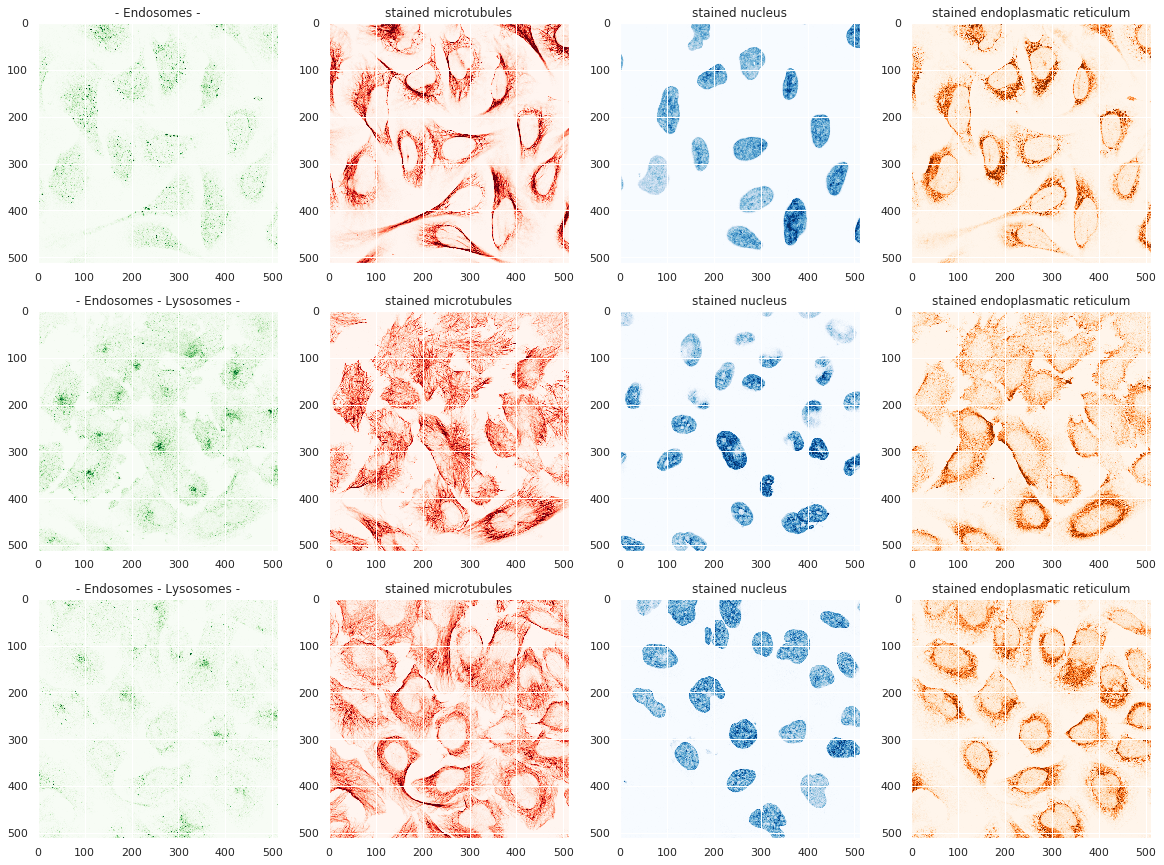

In [17]:
file_ids, images = next(iterator)

fig, ax = plt.subplots(len(file_ids),4,figsize=(20,5*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))

### Take-Away

* Looking at this few examples we can already obtain some insights:
    * The staining of target proteins in the green channel was not equally successful. The **images differ in their intensities and the target proteins are not always located the same way**. The first image you can get by the loader shows endosomes that are spread all over the cells and in the second and third you can find endosomes and lysosomes more concetrated around the nucleus. 
    * Especially **in the red channel we can see morphological differences**. It looks like if the cells are of different types. This is just an assumption but perhaps one could use the red channel information to reveal cell types. 

## Building a baseline model

### K-Fold Cross-Validation

Let's see how many test and train samples we have in this competition:

In [18]:
train_files = listdir("../input/train")
test_files = listdir("../input/test")
percentage = np.round(len(test_files) / len(train_files) * 100)

print("The test set size turns out to be {} % compared to the train set.".format(percentage))

The test set size turns out to be 38.0 % compared to the train set.


To understand the performance of our model we will use **k-fold cross validation**. The train data is splitted into k chunks and each chunk is used once for testing the prediction performance whereas the others are used for training. As our targets show relationships seemed to be grouped somehow the performance per test chunk probably highly depends on the target distribution per test chunk. For example there could be chunks with very seldom targets that may obtain a bad score and some chunks with very common targets and a very good score. To reduce this effect, we will **repeat the K-Fold several times** and look at scoing distributions in the end.

As our test data is 38 % of size compared to the train set it makes sense to use 3-Fold cross validation where the test set is 33 % of size compared to the train set. As we are working with neural networks that can be demanding in computational resources, let's only use 2 repetitions. 

In [19]:
from sklearn.model_selection import RepeatedKFold

splitter = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)

This splitter is now a generator. Hence if you call splitters split method it will yield one Fold of the repeated K-Folds. Consequently if we choose n_repeats=2 we will end up with 6 Folds in total: 3 Folds for the first cross validation and again 3 Folds for the repeated cross validation. We will perform the splitting on the image ids. This way we can easily load images and targets given the chunk ids. **Due to performance reasons I will only use one cv-fold to explore results and one repeat!**

In [20]:
partitions = []

for train_idx, test_idx in splitter.split(train_labels.index.values):
    partition = {}
    partition["train"] = train_labels.Id.values[train_idx]
    partition["validation"] = train_labels.Id.values[test_idx]
    partitions.append(partition)
    print("TRAIN:", train_idx, "TEST:", test_idx)
    print("TRAIN:", len(train_idx), "TEST:", len(test_idx))

TRAIN: [    1     2     3 ... 31063 31064 31065] TEST: [    0     4     6 ... 31069 31070 31071]
TRAIN: 20714 TEST: 10358
TRAIN: [    0     4     6 ... 31069 31070 31071] TEST: [    1     2     3 ... 31060 31061 31065]
TRAIN: 20715 TEST: 10357
TRAIN: [    0     1     2 ... 31069 31070 31071] TEST: [   10    11    13 ... 31062 31063 31064]
TRAIN: 20715 TEST: 10357


In [21]:
partitions[0]["train"][0:5]

array(['000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0',
       '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0',
       '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0',
       '001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0',
       '002daad6-bbc9-11e8-b2bc-ac1f6b6435d0'], dtype=object)

### Collecting ideas

Next we need to setup a simple baseline model. This need not be very complex or very good. Its our first attempt to play with and to figure out how to improve. For this purpose let's use the deep learning library [keras](https://keras.io/). This tools makes it easy for us to build and train neural networks. First of all, we should collect some ideas:

* To **stay simple let's use only the green channel image of our images per id**. The competition says that it shows the stained target proteins and consequently it's hopefully the most informative one. The other images are like references showing microtubules, nucleus and endoplasmatic reticulum. We don't acutally now how informative they are and in our current state they would blow up our neural network with a huge amount of network weigths that we might not need.
* Let's use **generators to only load data images of our batch and not all in once**. Using keras fit_generator, evaluate_generator and predict_generator we can directly connect them to keras without worrying much about how keras does its job. For this purpose I highly follow a descprition of a post in the www for which you will find the link below.
* It could be advantegous to write a **small class that does simple preprocessing per image.** This way we can easily change something of this phase without producing chaos in the model itself or during data loading.   
* I'm going to use a **small class that hold parameters that are used or shared between the data loader, the image preprocessor and the baseline model**. Passing an instance of this class to them reduced the risk of setting different parameters and obtaining mismatch errors for example during build & compile of the network layers. 


### Shared Parameter class

In [22]:
class ModelParameter:
    
    def __init__(self, basepath,
                 num_classes=28,
                 image_rows=512,
                 image_cols=512,
                 batch_size=32,
                 n_channels=1,
                 row_scale_factor=4,
                 col_scale_factor=4,
                 shuffle=False,
                 n_epochs=1):
        self.basepath = basepath
        self.num_classes = num_classes
        self.image_rows = image_rows
        self.image_cols = image_cols
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.row_scale_factor = row_scale_factor
        self.col_scale_factor = col_scale_factor
        self.scaled_row_dim = np.int(self.image_rows / self.row_scale_factor)
        self.scaled_col_dim = np.int(self.image_cols / self.col_scale_factor)
        self.n_epochs = n_epochs

Ok, now we will create an instance of this class and pass it to the DataGenerator, the BaseLineModel and the ImagePreprocessor.

In [23]:
parameter = ModelParameter(train_path)

In [24]:
# initialize other parameters
parameter_moreepoch = ModelParameter(train_path,n_epochs=10)
parameter_morechannels = ModelParameter(train_path,n_channels=4)

### Image Preprocessor

Let's write a simple image preprocessor that handles for example the rescaling of the images. Perhaps we can expand its functionality during improvement of the baseline model. 

In [25]:
from skimage.transform import resize

class ImagePreprocessor:
    
    def __init__(self, modelparameter):
        self.parameter = modelparameter
        self.basepath = self.parameter.basepath
        self.scaled_row_dim = self.parameter.scaled_row_dim
        self.scaled_col_dim = self.parameter.scaled_col_dim
        self.n_channels = self.parameter.n_channels
    
    def preprocess(self, image):
        image = self.resize(image)
        image = self.reshape(image)
        image = self.normalize(image)
        return image
    
    def resize(self, image):
        image = resize(image, (self.scaled_row_dim, self.scaled_col_dim))
        return image
    
    def reshape(self, image):
        image = np.reshape(image, (image.shape[0], image.shape[1], self.n_channels))
        return image
    
    def normalize(self, image):
        image /= 255 
        return image
    
    def load_image(self, image_id):
        image = np.zeros(shape=(512,512,4))
        image[:,:,0] = imread(self.basepath + image_id + "_green" + ".png")
        image[:,:,1] = imread(self.basepath + image_id + "_blue" + ".png")
        image[:,:,2] = imread(self.basepath + image_id + "_red" + ".png")
        image[:,:,3] = imread(self.basepath + image_id + "_yellow" + ".png")
        return image[:,:,0:self.parameter.n_channels]
        

Let's create an instance of this preprocessor and pass it to the data generator.

In [26]:
preprocessor = ImagePreprocessor(parameter)
preprocessor_moreepoch = ImagePreprocessor(parameter_moreepoch)
preprocessor_morechannels = ImagePreprocessor(parameter_morechannels)

#### Looking at a preprocessed example image

(512, 512)
(128, 128, 1)


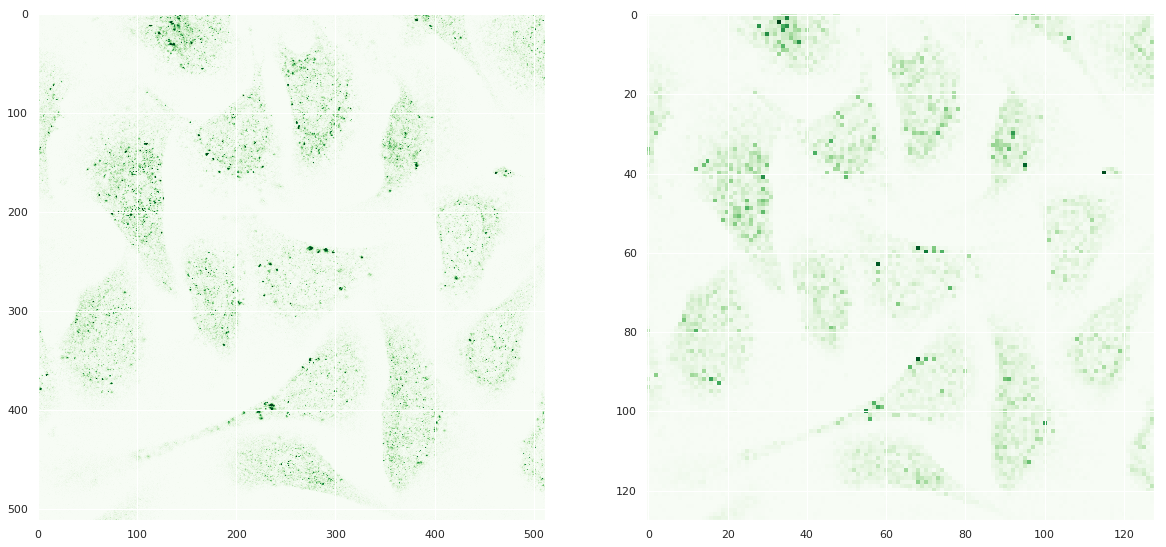

In [27]:
example = images[0,0]
preprocessed = preprocessor.preprocess(example)
print(example.shape)
print(preprocessed.shape)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(example, cmap="Greens")
ax[1].imshow(preprocessed.reshape(parameter.scaled_row_dim,parameter.scaled_col_dim), cmap="Greens")

You can see that we have lost a lot of information by downscaling the image!

### Data Generator

I highly build upon the [nice data generator presented by Shervine Amidi.](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) Thank you! :-) 


In [28]:
import keras

class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, list_IDs, labels, modelparameter, imagepreprocessor):
        self.params = modelparameter
        self.labels = labels
        self.list_IDs = list_IDs
        self.dim = (self.params.scaled_row_dim, self.params.scaled_col_dim)
        self.batch_size = self.params.batch_size
        self.n_channels = self.params.n_channels
        self.num_classes = self.params.num_classes
        self.shuffle = self.params.shuffle
        self.preprocessor = imagepreprocessor
        self.on_epoch_end()
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def get_targets_per_image(self, identifier):
        return self.labels.loc[self.labels.Id==identifier].drop(
                ["Id", "Target", "number_of_targets"], axis=1).values
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.num_classes), dtype=int)
        # Generate data
        for i, identifier in enumerate(list_IDs_temp):
            # Store sample
            image = self.preprocessor.load_image(identifier)
            image = self.preprocessor.preprocess(image)
            X[i] = image
            # Store class
            y[i] = self.get_targets_per_image(identifier)
        return X, y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

Using TensorFlow backend.


In [29]:
class PredictGenerator:
    
    def __init__(self, predict_Ids, imagepreprocessor, predict_path):
        self.preprocessor = imagepreprocessor
        self.preprocessor.basepath = predict_path
        self.identifiers = predict_Ids
    
    def predict(self, model):
        y = np.empty(shape=(len(self.identifiers), self.preprocessor.parameter.num_classes))
        for n in range(len(self.identifiers)):
            image = self.preprocessor.load_image(self.identifiers[n])
            image = self.preprocessor.preprocess(image)
            image = image.reshape((1, *image.shape))
            y[n] = model.predict(image)
        return y

### CNN Baseline model using keras

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta, Adam
from keras.models import load_model

In [31]:
class BaseLineModel:
    
    def __init__(self, modelparameter):
        self.params = modelparameter
        self.num_classes = self.params.num_classes
        self.img_rows = self.params.scaled_row_dim
        self.img_cols = self.params.scaled_col_dim
        self.n_channels = self.params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.my_metrics = ['accuracy']
    
    def build_model(self):
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
        self.model.add(Conv2D(32, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(self.num_classes, activation='sigmoid'))
    
    def compile_model(self):
        self.model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=self.my_metrics)
    
    def set_generators(self, train_generator, validation_generator):
        self.training_generator = train_generator
        self.validation_generator = validation_generator
    
    def learn(self):
        return self.model.fit_generator(generator=self.training_generator,
                    validation_data=self.validation_generator,
                    epochs=self.params.n_epochs, 
                    use_multiprocessing=True,
                    workers=8)
    
    def score(self):
        return self.model.evaluate_generator(generator=self.validation_generator,
                                      use_multiprocessing=True, 
                                      workers=8)
    
    def predict(self, predict_generator):
        y = predict_generator.predict(self.model)
        return y
    
    def save(self, modeloutputpath):
        self.model.save(modeloutputpath)
    
    def load(self, modelinputpath):
        self.model = load_model(modelinputpath)

### CNN VGG16 model using keras

In [32]:
class VGGModel:
    
    def __init__(self, modelparameter):
        self.params = modelparameter
        self.num_classes = self.params.num_classes
        self.img_rows = self.params.scaled_row_dim
        self.img_cols = self.params.scaled_col_dim
        self.n_channels = self.params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.my_metrics = ['accuracy']
        self.chanDim = -1
    
    def build_model(self):
        self.model = Sequential()
        # CONV => RELU => POOL
        self.model.add(Conv2D(32, (3, 3), padding="same", input_shape=self.input_shape,activation='relu'))
        self.model.add(BatchNormalization(axis=self.chanDim))
        self.model.add(MaxPooling2D(pool_size=(3, 3)))
        self.model.add(Dropout(0.25))
        # (CONV => RELU) * 2 => POOL
        self.model.add(Conv2D(64, (3, 3), padding="same",activation='relu'))
        self.model.add(BatchNormalization(axis=self.chanDim))
        self.model.add(Conv2D(64, (3, 3), padding="same",activation='relu'))
        self.model.add(BatchNormalization(axis=self.chanDim))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))
        # (CONV => RELU) * 2 => POOL
        self.model.add(Conv2D(128, (3, 3), padding="same",activation='relu'))
        self.model.add(BatchNormalization(axis=self.chanDim))
        self.model.add(Conv2D(128, (3, 3), padding="same",activation='relu'))
        self.model.add(BatchNormalization(axis=self.chanDim))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        self.model.add(Flatten())
        self.model.add(Dense(1024,activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        
        # use a *softmax* activation for single-label classification
        # and *sigmoid* activation for multi-label classification
        self.model.add(Dense(self.num_classes, activation='sigmoid'))

    
    def compile_model(self):
        self.model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=self.my_metrics)
    
    def set_generators(self, train_generator, validation_generator):
        self.training_generator = train_generator
        self.validation_generator = validation_generator
    
    def learn(self):
        return self.model.fit_generator(generator=self.training_generator,
                    validation_data=self.validation_generator,
                    epochs=self.params.n_epochs, 
                    use_multiprocessing=True,
                    workers=8,verbose=1)
    
    def score(self):
        return self.model.evaluate_generator(generator=self.validation_generator,
                                      use_multiprocessing=True, 
                                      workers=8)
    
    def predict(self, predict_generator):
        y = predict_generator.predict(self.model)
        return y
    
    def save(self, modeloutputpath):
        self.model.save(modeloutputpath)
    
    def load(self, modelinputpath):
        self.model = load_model(modelinputpath)

### Training the baseline on the sample dataset

We have tried to train the baseline on the whole dataset of the first cross-validation fold. However, due to the resourse limit, it never finishes. Therefore, we choose to downsample to training 2000 samples /validation 400 samples.

In [34]:
# Datasets
partition = partitions[0]
labels = train_labels

print("Number of samples in train: {}".format(len(partition["train"])))
print("Number of samples in validation: {}".format(len(partition["validation"])))

Number of samples in train: 20714
Number of samples in validation: 10358


In [35]:
training_generator = DataGenerator(partition['train'][:2000], labels, parameter, preprocessor)
validation_generator = DataGenerator(partition['validation'][:400], labels, parameter, preprocessor)
predict_generator = PredictGenerator(partition['validation'][:400], preprocessor, train_path)

In [37]:
model = BaseLineModel(parameter)
model.build_model()
model.compile_model()
model.set_generators(training_generator, validation_generator)
history = model.learn()
model.save("baseline_model.h5")
proba_predictions = model.predict(predict_generator)
baseline_proba_predictions = pd.DataFrame(proba_predictions, columns=train_labels.drop(
        ["Target", "number_of_targets", "Id"], axis=1).columns)
baseline_proba_predictions.to_csv("baseline_predictions.csv")

#baseline_proba_predictions = pd.read_csv("baseline_predictions.csv", index_col=0)

Epoch 1/1
62/62 [==============================] - 136s 2s/step - loss: 0.3042 - acc: 0.8832 - val_loss: 0.1832 - val_acc: 0.9388


Since we see a much lower validation loss and a higher validation accuracy than for the training, we know the model is underfitting -- likely because it is far too simple -- but we also expect that this is occuring because we are not getting a respective distribution of the actual dataset.

Now let's try to use 5000 training samples, and 500 validation samples.

In [39]:
training_generator = DataGenerator(partition['train'][:5000], labels, parameter, preprocessor)
validation_generator = DataGenerator(partition['validation'][:500], labels, parameter, preprocessor)
predict_generator = PredictGenerator(partition['validation'][:500], preprocessor, train_path)

In [41]:
model = BaseLineModel(parameter)
model.build_model()
model.compile_model()
model.set_generators(training_generator, validation_generator)
history = model.learn()
model.save("baseline_model.h5")
proba_predictions = model.predict(predict_generator)
baseline_proba_predictions = pd.DataFrame(proba_predictions, columns=train_labels.drop(
        ["Target", "number_of_targets", "Id"], axis=1).columns)
baseline_proba_predictions.to_csv("baseline_predictions_1.csv")

#baseline_proba_predictions = pd.read_csv("baseline_predictions.csv", index_col=0)

Epoch 1/1
155/156 [============================>.] - ETA: 1s - loss: 0.2410 - acc: 0.9186Epoch 1/1
Epoch 1/1
156/156 [==============================] - 303s 2s/step - loss: 0.2407 - acc: 0.9188 - val_loss: 0.1760 - val_acc: 0.9398


We can see that increasing the number of sample drastically reduced the amount of underfitting (confirming our second hypothesis) but we are still underfitting, so we want to see if we can improve that over time.

Now let's increase the number of epoches we use to 10 epoches and see how the accuracy improves.

In [36]:
preprocessor_moreepoch = ImagePreprocessor(parameter_moreepoch)
preprocessor_morechannels = ImagePreprocessor(parameter_morechannels)

In [37]:
training_generator = DataGenerator(partition['train'][:5000], labels, parameter_moreepoch, preprocessor_moreepoch)
validation_generator = DataGenerator(partition['validation'][:500], labels, parameter_moreepoch, preprocessor_moreepoch)
predict_generator = PredictGenerator(partition['validation'][:500], preprocessor_moreepoch, train_path)

In [45]:
model = BaseLineModel(parameter_moreepoch)
model.build_model()
model.compile_model()
model.set_generators(training_generator, validation_generator)
history = model.learn()
model.save("baseline_model.h5")
proba_predictions = model.predict(predict_generator)
baseline_proba_predictions = pd.DataFrame(proba_predictions, columns=train_labels.drop(
        ["Target", "number_of_targets", "Id"], axis=1).columns)
baseline_proba_predictions.to_csv("baseline_predictions_2.csv")

Epoch 1/10
156/156 [==============================] - 279s 2s/step - loss: 0.2497 - acc: 0.9160 - val_loss: 0.1800 - val_acc: 0.9396
Epoch 2/10
156/156 [==============================] - 265s 2s/step - loss: 0.1938 - acc: 0.9394 - val_loss: 0.1753 - val_acc: 0.9388
Epoch 3/10
156/156 [==============================] - 266s 2s/step - loss: 0.1855 - acc: 0.9411 - val_loss: 0.1743 - val_acc: 0.9390
Epoch 4/10
156/156 [==============================] - 267s 2s/step - loss: 0.1826 - acc: 0.9416 - val_loss: 0.1744 - val_acc: 0.9393
Epoch 5/10
156/156 [==============================] - 267s 2s/step - loss: 0.1801 - acc: 0.9418 - val_loss: 0.1739 - val_acc: 0.9388
Epoch 6/10
156/156 [==============================] - 269s 2s/step - loss: 0.1790 - acc: 0.9418 - val_loss: 0.1741 - val_acc: 0.9389
Epoch 7/10
156/156 [==============================] - 270s 2s/step - loss: 0.1781 - acc: 0.9424 - val_loss: 0.1749 - val_acc: 0.9392
Epoch 8/10
156/156 [==============================] - 268s 2s/step - 

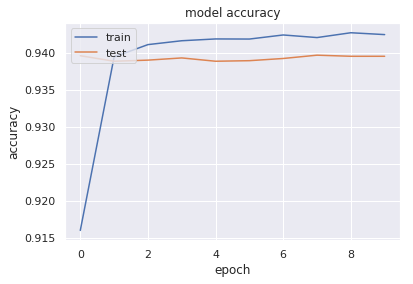

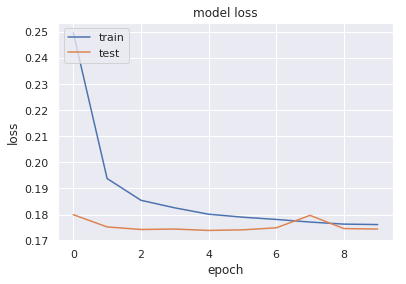

In [46]:
# plot loss and accuracy over time
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Here we see that the training accuracy quickly surpasses the validation accuracy, even as the loss never does (and also the validation loss basically does not change at all). This tells us that our model is now overfitting to the training data, and suggests that we have probably exhausted the capabilities of this training data set.

### Use four filters at the same time to train the baseline model

In [38]:
training_generator = DataGenerator(partition['train'][:5000], labels, parameter_morechannels, preprocessor_morechannels)
validation_generator = DataGenerator(partition['validation'][:500], labels, parameter_morechannels, preprocessor_morechannels)
predict_generator = PredictGenerator(partition['validation'][:500], preprocessor_morechannels, train_path)

In [40]:
model = BaseLineModel(parameter_morechannels)
model.build_model()
model.compile_model()
model.set_generators(training_generator, validation_generator)
history = model.learn()
model.save("baseline_model.h5")
proba_predictions = model.predict(predict_generator)
baseline_proba_predictions = pd.DataFrame(proba_predictions, columns=train_labels.drop(
        ["Target", "number_of_targets", "Id"], axis=1).columns)
baseline_proba_predictions.to_csv("baseline_predictions_3.csv")

Epoch 1/1
156/156 [==============================] - 345s 2s/step - loss: 0.2631 - acc: 0.9077 - val_loss: 0.1759 - val_acc: 0.9397


Here we used four channels (green filter + 3 other reference filters) to predict the protein localization label. One reason that the accuracy doesn't seem to improve might be the model itself is too simple. With only two convolutional layers, the machine might not be able to learn the differences between channels. If resource permits, we can also try to use VGG16 model with 4 channels.

### Train VGG Model

Start training with 1 epoch.

In [41]:
training_generator = DataGenerator(partition['train'][:2000], labels, parameter, preprocessor)
validation_generator = DataGenerator(partition['validation'][:400], labels, parameter, preprocessor)
predict_generator = PredictGenerator(partition['validation'][:400], preprocessor, train_path)

In [37]:
model = VGGModel(parameter)
model.build_model()
model.compile_model()
model.set_generators(training_generator, validation_generator)
history = model.learn()
model.save("vgg16_model.h5")
proba_predictions = model.predict(predict_generator)
vgg_proba_predictions = pd.DataFrame(proba_predictions, columns=train_labels.drop(
        ["Target", "number_of_targets", "Id"], axis=1).columns)
vgg_proba_predictions.to_csv("vgg16_predictions.csv")

Epoch 1/1
62/62 [==============================] - 257s 4s/step - loss: 0.7049 - acc: 0.6367 - val_loss: 0.5577 - val_acc: 0.7569


This first epoch is clearly underfitting. Additionally, it does not seem to immediately be performing as well. However, this is a fake worse performance -- the baseline model (as we see later) looked like it was performing well simply because it was very rarely predicting anything, so the loss function was rewarding it for not making wrong-predictions even though it was simultaneously not making correct predictions. Since VGG16 model can learn much more complicated traits of the images, it does not make that same mistake, thus it is having a lower accuracy due to making incorrect predictions.

Let's increase the train/validation sample size and train 1 epoch.

In [42]:
training_generator = DataGenerator(partition['train'][:5000], labels, parameter, preprocessor)
validation_generator = DataGenerator(partition['validation'][:500], labels, parameter, preprocessor)
predict_generator = PredictGenerator(partition['validation'][:500], preprocessor, train_path)
model = VGGModel(parameter)
model.build_model()
model.compile_model()
model.set_generators(training_generator, validation_generator)
history = model.learn()
model.save("vgg16_model.h5")
proba_predictions = model.predict(predict_generator)
vgg_proba_predictions = pd.DataFrame(proba_predictions, columns=train_labels.drop(
        ["Target", "number_of_targets", "Id"], axis=1).columns)
vgg_proba_predictions.to_csv("vgg16_predictions_1.csv")

Epoch 1/1
156/156 [==============================] - 605s 4s/step - loss: 0.4398 - acc: 0.8100 - val_loss: 0.1904 - val_acc: 0.9393


The training accuracy went from 0.63 to 0.81 as we increased the training data size. However, it also takes longer to train the model (10 mins per epoch). 

In [ ]:
training_generator = DataGenerator(partition['train'][:2000], labels, parameter, preprocessor)
validation_generator = DataGenerator(partition['validation'][:400], labels, parameter, preprocessor)
predict_generator = PredictGenerator(partition['validation'][:400], preprocessor, train_path)

Then we try training 10 epoches, with 2000 training and 400 validation samples.

In [38]:
model = VGGModel(parameter_moreepoch)
model.build_model()
model.compile_model()
model.set_generators(training_generator, validation_generator)
history = model.learn()
model.save("vgg16_model.h5")
proba_predictions = model.predict(predict_generator)
vgg_proba_predictions = pd.DataFrame(proba_predictions, columns=train_labels.drop(
        ["Target", "number_of_targets", "Id"], axis=1).columns)
vgg_proba_predictions.to_csv("vgg16_predictions.csv")

Epoch 1/10
62/62 [==============================] - 256s 4s/step - loss: 0.7064 - acc: 0.6441 - val_loss: 0.5457 - val_acc: 0.7817
Epoch 2/10
62/62 [==============================] - 239s 4s/step - loss: 0.2908 - acc: 0.9123 - val_loss: 0.2830 - val_acc: 0.9304
Epoch 3/10
62/62 [==============================] - 239s 4s/step - loss: 0.1926 - acc: 0.9402 - val_loss: 0.2145 - val_acc: 0.9239
Epoch 4/10
62/62 [==============================] - 241s 4s/step - loss: 0.1786 - acc: 0.9431 - val_loss: 0.1846 - val_acc: 0.9394
Epoch 5/10
62/62 [==============================] - 238s 4s/step - loss: 0.1714 - acc: 0.9429 - val_loss: 0.1878 - val_acc: 0.9367
Epoch 6/10
62/62 [==============================] - 237s 4s/step - loss: 0.1655 - acc: 0.9444 - val_loss: 0.9006 - val_acc: 0.8031
Epoch 7/10
62/62 [==============================] - 239s 4s/step - loss: 0.1640 - acc: 0.9431 - val_loss: 0.2147 - val_acc: 0.9381
Epoch 8/10
62/62 [==============================] - 241s 4s/step - loss: 0.1537 - a

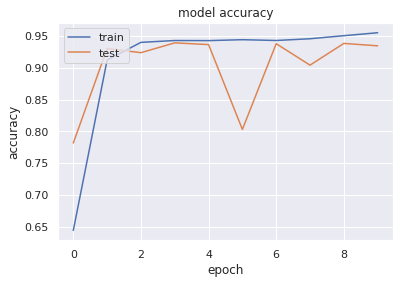

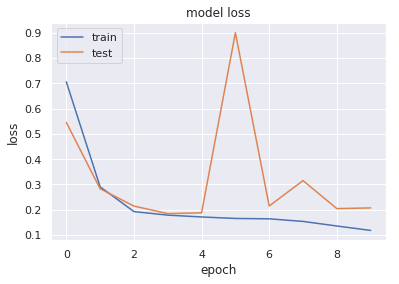

In [39]:
# plot loss and accuracy over time
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Due to the limit of GPU resource and RAM space, we are training 10 epoch of VGG16 model with 2000 training sample, 400 validation sample. This training run takes about 1 hour to finish. A larger training sample will results in the server to stall. We can see that test accuracy is not stablily decreasing over time. This means that the VGG16 model is learning something new every epoch. As we mentioned that VGG16 model can learn much more complicated traits of the images, therefore the training accuracy after 10 epoch reaches 95.5% (a higher training accuracy than the baseline model trained with 10 epochs).

## What do the baseline results tell us?

Let's have a look at predicted probabilites per target class:

In [47]:
validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])]

In [44]:
baseline_proba_predictions.tail()

,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
10353,0.405442,0.019475,0.096490,0.040893,0.051506,0.080357,0.026848,0.101955,0.016413,0.007232,...,0.011176,0.044507,0.009478,0.061817,0.016543,0.093321,0.022078,0.182599,0.014503,0.006611
10354,0.391198,0.018363,0.098836,0.045386,0.051529,0.082826,0.025817,0.103776,0.016171,0.007529,...,0.009710,0.043578,0.009023,0.052368,0.016416,0.097127,0.022203,0.160257,0.016091,0.006242
10355,0.410812,0.020428,0.098244,0.039863,0.051948,0.078806,0.027718,0.101767,0.016680,0.007337,...,0.011656,0.045337,0.009906,0.065310,0.016901,0.093401,0.022121,0.191832,0.014297,0.006886
10356,0.499616,0.032202,0.087654,0.008287,0.033825,0.033290,0.042252,0.065632,0.020358,0.003218,...,0.031055,0.048695,0.010913,0.252322,0.014540,0.044719,0.019315,0.509550,0.004295,0.008241
10357,0.428234,0.023606,0.099626,0.040282,0.057131,0.083005,0.031554,0.107602,0.018144,0.008103,...,0.014800,0.051060,0.011655,0.080586,0.019183,0.095330,0.024362,0.217976,0.014662,0.008476


In [45]:
proba_predictions = baseline_proba_predictions.values

/home/xrq980914/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Percentage')

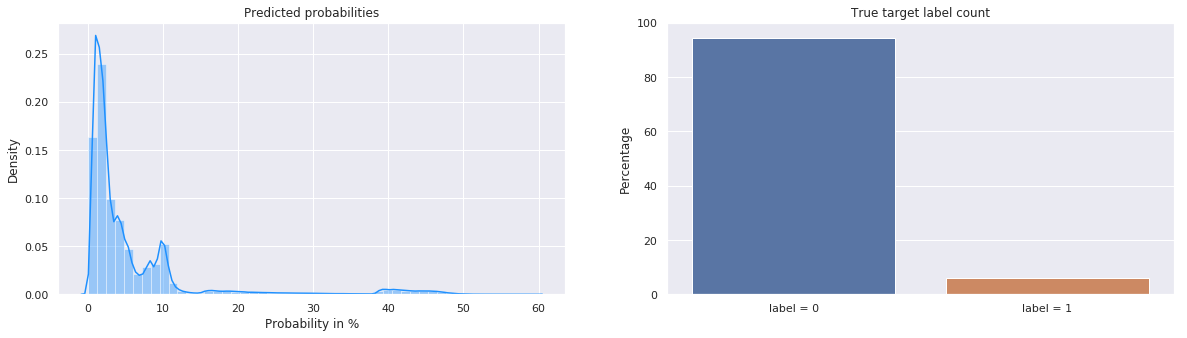

In [46]:
hot_values = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).values.flatten()
one_hot = (hot_values.sum()) / hot_values.shape[0] * 100
zero_hot = (hot_values.shape[0] - hot_values.sum()) / hot_values.shape[0] * 100

fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(proba_predictions.flatten() * 100, color="DodgerBlue", ax=ax[0])
ax[0].set_xlabel("Probability in %")
ax[0].set_ylabel("Density")
ax[0].set_title("Predicted probabilities")
sns.barplot(x=["label = 0", "label = 1"], y=[zero_hot, one_hot], ax=ax[1])
ax[1].set_ylim([0,100])
ax[1].set_title("True target label count")
ax[1].set_ylabel("Percentage")

### Take-Away

* We can see that our model was always very uncertain to predict the presence of a target protein. All probabilities are close to zero and there are only a few with targets where our model predicted a protein structure with higher than 10 %.
* If we take a look at the true target label count we can see that most of our targets are filled with zero. This corresponds to an absence of corresponding target proteins. This makes sense: For each image we have a high probability to contain either 1 or 2 target protein structures. Their label values are one whereas all others are zero. 
* Consequently our high accuracy belongs to the high correct prediction of the absence of target proteins. In contrast we unfortunately weren't predicting the presence of target proteins. 

### To which targets do the high and small predicted probabilities belong to?

Text(0.5, 1.0, 'Standard deviation of predicted probability per class over all samples')

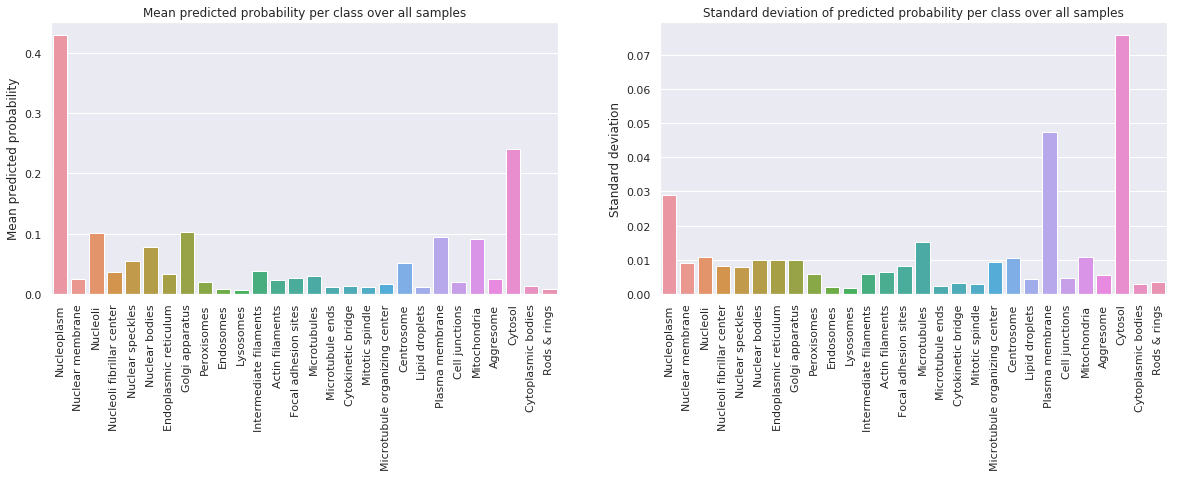

In [47]:
mean_predictions = np.mean(proba_predictions, axis=0)
std_predictions = np.std(proba_predictions, axis=0)
mean_targets = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).mean()

labels = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).columns.values

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x=labels,
            y=mean_predictions,
            ax=ax[0])
ax[0].set_xticklabels(labels=labels,
                      rotation=90)
ax[0].set_ylabel("Mean predicted probability")
ax[0].set_title("Mean predicted probability per class over all samples")
sns.barplot(x=labels,
           y=std_predictions,
           ax=ax[1])
ax[1].set_xticklabels(labels=labels,
                      rotation=90)
ax[1].set_ylabel("Standard deviation")
ax[1].set_title("Standard deviation of predicted probability per class over all samples")

Text(0.5, 1.0, 'Percentage of hot counts (ones) per target class')

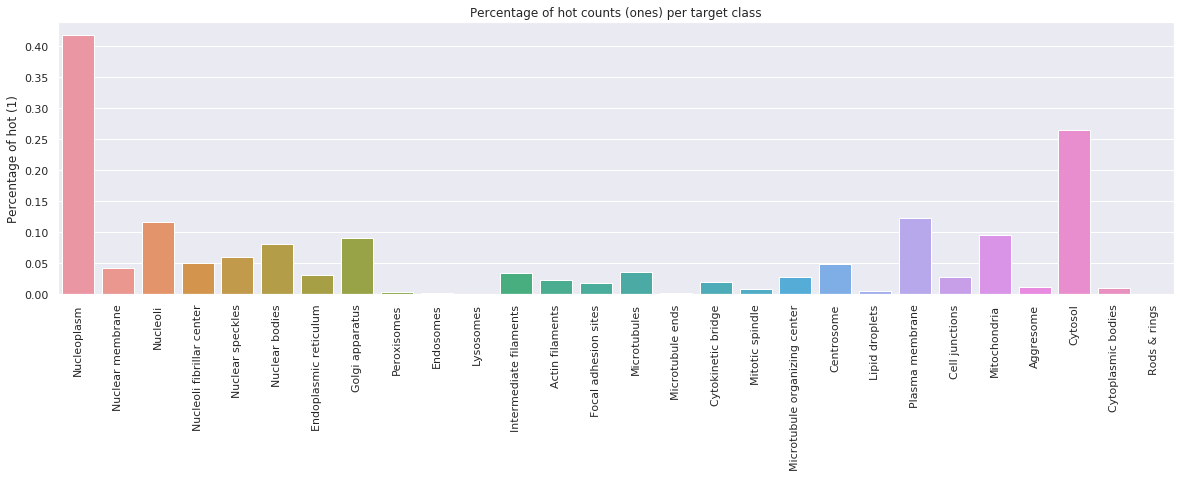

In [48]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.barplot(x=labels, y=mean_targets.values, ax=ax)
ax.set_xticklabels(labels=labels,
                      rotation=90)
ax.set_ylabel("Percentage of hot (1)")
ax.set_title("Percentage of hot counts (ones) per target class")

### Take-Away

* Our baseline model seemed to learn something even if this something does not look very nice. 
* Taking a look at the standard deviation we can see that all samples have nearly the same predicted values. There is no deviation, no difference between them.

## Future work

* We should train on the whole dataset if resource permits.
* Add external data. Some top Kaggle scorers for this competition are using extra external samples from the Human Protein Atlas. By doing some data augmentation, we can triple the data size while still maintains the same data distribution.
* We can use higher resolution images, which might encode more information. There is a higher-resolution version of the dataset avai

* Try other architectures
* Use pre-trained models
* Try submitting to Kaggle to get a sense of how our model is performing relative to other models
* Why doesn’t validation accuracy change over time? 
    * We tried partitioning the dataset differently in case the validation data was not a representative sample of the data without effect. 
    * When we incorporate all 4 channels, val_acc actually improve over epochs
